In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# reading the Dataset
Customer_df = pd.read_csv("Customers.csv")
print(Customer_df.head())
print("*****************")
products_df = pd.read_csv("Products.csv")
print(products_df.head())
print("*****************")
Transaction_df = pd.read_csv("Transactions.csv")
print(Transaction_df.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
*****************
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
*****************
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-

In [6]:
# Merge datasets to link customer and transaction data
data = Transaction_df.merge(Customer_df, on='CustomerID').merge(products_df, on='ProductID')
data.tail(6)

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
994,T00586,C0179,P093,2024-08-31 22:33:10,1,304.94,304.94,Donald Miller,Europe,2022-10-16,TechPro Vase,Home Decor,304.94
995,T00630,C0031,P093,2024-10-08 23:58:14,2,609.88,304.94,Tina Miller,South America,2024-04-11,TechPro Vase,Home Decor,304.94
996,T00672,C0165,P044,2024-07-28 00:09:49,4,75.28,18.82,Juan Mcdaniel,South America,2022-04-09,ActiveWear Running Shoes,Clothing,18.82
997,T00711,C0165,P044,2024-06-11 15:51:14,4,75.28,18.82,Juan Mcdaniel,South America,2022-04-09,ActiveWear Running Shoes,Clothing,18.82
998,T00878,C0165,P044,2024-09-24 21:15:21,3,56.46,18.82,Juan Mcdaniel,South America,2022-04-09,ActiveWear Running Shoes,Clothing,18.82
999,T00157,C0169,P044,2024-11-09 09:07:36,2,37.64,18.82,Jennifer Shaw,South America,2023-04-13,ActiveWear Running Shoes,Clothing,18.82


In [7]:
# Merge datasets to link customer and transaction data
data = Transaction_df.merge(Customer_df, on='CustomerID').merge(products_df, on='ProductID')

# Feature Engineering: Aggregate features like total spend, purchase frequency
customer_data = data.groupby('CustomerID').agg(
    total_spend=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    purchase_frequency=pd.NamedAgg(column='TransactionID', aggfunc='count'),
    avg_transaction_value=pd.NamedAgg(column='TotalValue', aggfunc='mean')
)

In [9]:
# Normalize the data
import warnings
warnings.filterwarnings("ignore")
scaler = StandardScaler()
customer_data_scaled = pd.DataFrame(scaler.fit_transform(customer_data), columns=customer_data.columns)

# Perform K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Choosing 5 clusters
customer_data_scaled['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Evaluate Clustering with DB Index
db_index = davies_bouldin_score(customer_data_scaled.drop('Cluster', axis=1), customer_data_scaled['Cluster'])
print(f"DB Index: {db_index:.4f}")

DB Index: 0.8394


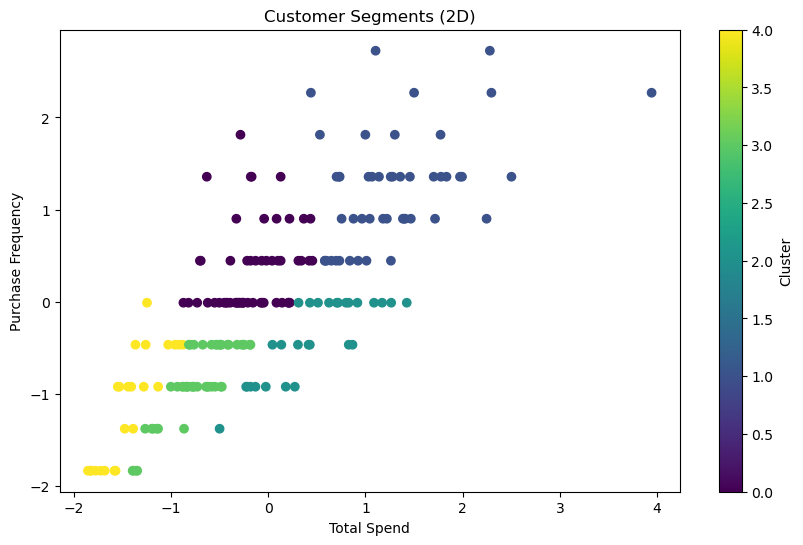

In [17]:
# Visualize Clusters in 2D (First two features)
plt.figure(figsize=(10, 6))
plt.scatter(customer_data_scaled['total_spend'], customer_data_scaled['purchase_frequency'], c=customer_data_scaled['Cluster'], cmap='viridis')
plt.title('Customer Segments (2D)')
plt.xlabel('Total Spend')
plt.ylabel('Purchase Frequency')
plt.colorbar(label='Cluster')
plt.savefig('Clusters in 2D')
plt.show()

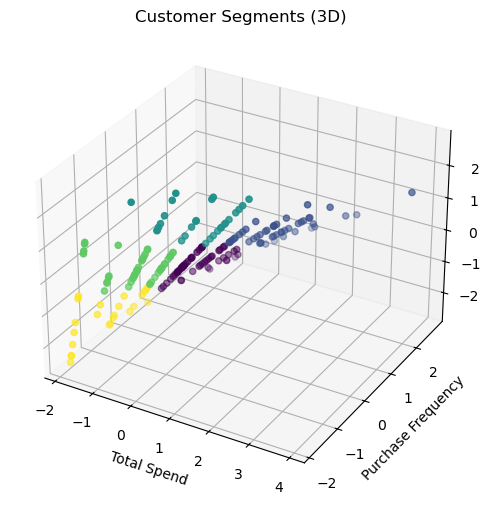

In [18]:
# Visualize Clusters in 3D (First three features)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(customer_data_scaled['total_spend'], customer_data_scaled['purchase_frequency'], customer_data_scaled['avg_transaction_value'],
           c=customer_data_scaled['Cluster'], cmap='viridis')
ax.set_title('Customer Segments (3D)')
ax.set_xlabel('Total Spend')
ax.set_ylabel('Purchase Frequency')
ax.set_zlabel('Avg Transaction Value')
plt.savefig('Clusters in 3D')
plt.show()

In [12]:
# Output Cluster Centers
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=customer_data.columns)
print("Cluster Centers (Original Scale):")
print(cluster_centers)

Cluster Centers (Original Scale):
   total_spend  purchase_frequency  avg_transaction_value
0  3170.717407            5.796296             557.285577
1  5839.123333            7.708333             767.863859
2  4317.132143            4.142857            1056.828643
3  2121.090435            3.086957             708.421467
4   871.697391            2.565217             334.738275


In [13]:
# Add Cluster Labels to the Original Data
customer_data['Cluster'] = customer_data_scaled['Cluster']
print(customer_data.head())

            total_spend  purchase_frequency  avg_transaction_value  Cluster
CustomerID                                                                 
C0001           3354.52                   5                670.904      NaN
C0002           1862.74                   4                465.685      NaN
C0003           2725.38                   4                681.345      NaN
C0004           5354.88                   8                669.360      NaN
C0005           2034.24                   3                678.080      NaN


In [14]:
# Save results
customer_data.to_csv("Customer_Segmentation.csv", index=False)